<h1> CMPE452 Assignment 2 - Classifying Wines using Feed-Forward NN with Backpropogation </h1>

<i>Authored by: Ben Pang (SN: 10085206)</i>

<h2> 1. Data Pre-Processing </h2>

First, we load the data into a Pandas Dataframe:

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("wine.csv")

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.9908,2.99,0.56,12.0,5
1,8.6,0.23,0.40,4.20,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,5
2,7.9,0.18,0.37,1.20,0.040,16.0,75.0,0.9920,3.18,0.63,10.8,5
3,6.6,0.16,0.40,1.50,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,7
4,8.3,0.42,0.62,19.25,0.040,41.0,172.0,1.0002,2.98,0.67,9.7,5


In [4]:
data.quality = pd.Categorical(data.quality)
data.describe(exclude=['category'])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000,2512.000000
mean,6.844885,0.286549,0.332663,6.466421,0.045946,35.644108,140.146497,0.994067,3.188093,0.489805,10.482310
std,0.815688,0.099314,0.119301,5.023958,0.022416,16.485827,41.686278,0.002992,0.149717,0.114548,1.305514
min,3.900000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.790000,0.220000,8.000000
25%,6.300000,0.220000,0.260000,1.800000,0.035000,24.000000,111.000000,0.991730,3.090000,0.410000,9.400000
50%,6.800000,0.280000,0.320000,5.250000,0.043000,34.000000,136.000000,0.993800,3.170000,0.470000,10.200000
75%,7.300000,0.330000,0.390000,10.050000,0.051000,46.000000,169.000000,0.996300,3.280000,0.540000,11.400000
max,10.300000,0.905000,1.000000,23.500000,0.346000,131.000000,344.000000,1.002410,3.820000,1.080000,14.200000


Next, we normalize the columns of the data set such that values lie in the same range. The quality labels are also replaced with their categorical index. This is important to the classification algorithm of our neural network model which uses the argmax of the output activations vector as the predicted label.

In [5]:
data.iloc[:, 0:11] = data.iloc[:, 0:11].apply(lambda x: x/x.max(), axis=0)
data['labels'] = data.quality.cat.codes
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,labels
0,0.786408,0.298343,0.41,0.061702,0.095376,0.083969,0.183140,0.988418,0.782723,0.518519,0.845070,5,0
1,0.834951,0.254144,0.40,0.178723,0.101156,0.129771,0.316860,0.992309,0.821990,0.490741,0.683099,5,0
2,0.766990,0.198895,0.37,0.051064,0.115607,0.122137,0.218023,0.989615,0.832461,0.583333,0.760563,5,0
3,0.640777,0.176796,0.40,0.063830,0.127168,0.366412,0.415698,0.988817,0.926702,0.481481,0.873239,7,1
4,0.805825,0.464088,0.62,0.819149,0.115607,0.312977,0.500000,0.997795,0.780105,0.620370,0.683099,5,0


In [6]:
data_X = data.iloc[:, 0:11]
data_D = data['labels']

We split the dataset into training and testing sets using a convenient tool from scikit-learn. We use a 7:3 train/test ratio for the splitting.

In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_D, test_D = train_test_split(data_X, data_D, test_size=0.3, random_state=17)

We ensure that the training set and testing set are statistically similar by examining their statistic properties:

In [8]:
train_X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000,1758.000000
mean,0.664471,0.316888,0.332167,0.276428,0.132580,0.274221,0.408038,0.991700,0.833107,0.450875,0.736131
std,0.078842,0.109071,0.119047,0.214527,0.064581,0.127459,0.124258,0.002970,0.038643,0.103563,0.091842
min,0.378641,0.088398,0.000000,0.025532,0.040462,0.015267,0.026163,0.984737,0.730366,0.203704,0.563380
25%,0.611650,0.243094,0.260000,0.076596,0.101879,0.175573,0.316860,0.989348,0.806283,0.379630,0.661972
50%,0.660194,0.309392,0.310000,0.221277,0.124277,0.267176,0.398256,0.991411,0.829843,0.435185,0.718310
75%,0.708738,0.364641,0.390000,0.429255,0.147399,0.358779,0.496366,0.993885,0.856021,0.500000,0.802817
max,1.000000,0.939227,1.000000,1.000000,1.000000,0.977099,1.000000,1.000000,1.000000,0.916667,1.000000


In [9]:
test_X.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,0.664740,0.316024,0.333820,0.272228,0.133285,0.267130,0.405922,0.991625,0.838012,0.459696,0.742994
std,0.080057,0.111353,0.119962,0.212159,0.065300,0.121941,0.113749,0.003021,0.040263,0.111501,0.092043
min,0.407767,0.121547,0.000000,0.025532,0.026012,0.022901,0.069767,0.985026,0.746073,0.240741,0.598592
25%,0.621359,0.234807,0.270000,0.076596,0.101156,0.183206,0.328488,0.989336,0.811518,0.379630,0.661972
50%,0.660194,0.298343,0.320000,0.225532,0.124277,0.259542,0.395349,0.991311,0.832461,0.444444,0.732394
75%,0.708738,0.364641,0.390000,0.425532,0.144509,0.343511,0.482558,0.993905,0.863874,0.509259,0.802817
max,0.951456,1.000000,0.860000,0.842553,0.783237,1.000000,0.909884,0.998793,0.992147,1.000000,0.978873


<h2> 2. Network Implementation </h2>

<h5> Structure </h5>

The network we implement will be a feed-forward NN with one hidden layer. We use one hidden layer because it is hypothesised that since one hidden layer is sufficient for most problems, it will suffice for this problem also. We choose to include 6 nodes in the hidden layer. Once again, we are not using network optimization in this implmentation so we hypothesize that 6 hidden nodes is sufficient for the job.

Under this setup, the network will have a total of 11\*6 + 6\*3 = 120 weights. Hence, 600 training examples are required to achieve an accuracy of 0.80. We have sufficient examples in our training data.

<h5> Initialization </h5>

We initialize the weights using the *uniform initialization* strategy, in which we draw the weights in each layer from a uniform distribution ranging from -1/(previous layer nodes) to 1/(previous layer nodes).

<h5> Parameters </h5>

For our stopping criterion, we use a simple epoch based approach in which we specify `num_epochs` as the number of times the algorithm loops through the training set. This will avoid the possibility of an endless loop. At the end of each epoch, we measure the prediction accuracy using the testing set. The graph of prediction accuracy per training epoch can be seen below.

The learning rate and momentum parameters were chosen from trial and error. We observe that choosing a learning rate that is too high causes the result to be chaotic, characterized by large fluctuations in the accuracy/training epochs graph. Choosing a momentum that is too high will prevent the algorithm from converging, characterized by a drastic degenerative dip in the accuracy/epoch graph.

In [13]:
import network
import matplotlib.pyplot as plt

layers = [11, 6, 3]
learning_rate = 0.001
momentum = 0.00001

net = network.bp_classifer(layers, learning_rate, momentum)

In [14]:
acc = net.train(train_X.as_matrix(), train_D.as_matrix(), test_X.as_matrix(), test_D.as_matrix(), num_epochs=200)

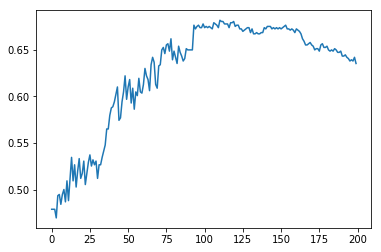

In [15]:
plt.figure()
plt.plot(acc)
plt.show()